# Parcels (Probably A Really Computationally Efficient Lagrangian Simulator)
A set of Python classes and methods to create customisable particle tracking simulations using output from Ocean Circulation models. Parcels can be used to track passive and active particulates such as water, plankton, plastic and fish.

> Documentation : https://oceanparcels.org/index.html  
> Github: https://github.com/OceanParcels/parcels  
> Installation : conda create -n py3_parcels -c conda-forge parcels jupyter cartopy ffmpeg

### General structure:

![alt text](parcels.png "Parcels componants")

1. **FieldSet**: Load and set up the (velocity) fields that your particles need to access.
2. **ParticleSet**: Define the type of particles you want to release, what Variables they have and what their initial conditions are.
3. **Kernels**: Define and compile the kernels that encode what your particles need to do each timestep and execute them.
4. **PartcleFile**: Write and store the output to a NetCDF file. 

In [1]:
import os, shutil

import math
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from cmocean import cm
from shapely.geometry import Polygon


from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile, Variable
from parcels import JITParticle 
from parcels import ErrorCode, AdvectionRK4

import warnings
warnings.filterwarnings("ignore")

---
### Methods

In [2]:
def plot_pretty(bbox, trails=None, bg_var=None, figsize=(7,7), date=None, 
                vmin=None, vmax=None, cmap=cm.thermal, **kwargs):
 
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # init figure, axe
    fig, ax = plt.subplots(1, 1, 
                           subplot_kw={'projection': ccrs.PlateCarree()},
                           figsize=figsize,
                          )
    ax.set_extent(bbox)
        
    if bg_var is not None:
        cm= bg_var.plot.pcolormesh(ax=ax,x="XC",y="YC", extend="neither",
                                   add_colorbar=False, cmap=cmap,
                                   vmin=vmin, vmax=vmax) 
        # add colorbar with the right size
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
        fig.add_axes(ax_cb)
        fig.colorbar(cm, cax=ax_cb)
    
    # set grid lines
    gl = ax.gridlines(draw_labels=True)
    # Hide the right and top axis graduation
    gl.top_labels = False
    gl.right_labels = False
    
    ax.coastlines(resolution='10m')
    if trails is not None:
        if trails.index.unique().size>1:
            trails.groupby('trajectory').apply(plot_trajectory, ax=ax)
        else:
            ax.plot(trails.lon, trails.lat, '.') 
            
    if date is not None:
        ax.set_title(date.strftime('%Y-%m-%d %H:%M'))

    return fig, ax

In [3]:
def plot_trajectory(df, 
                    ax=None, 
                    flag_drifters=0,
                    **kwargs,
                   ):
    """ plot single drifter trajectory
    
    Parameters
    ----------
    df: pandas.Dataframe
    ax: pyplot axis, optional
    flag_drifters: int, optional
        used to distinguish drifters 
    **kwargs: optional
        options for plot method
    """
    df = df.sort_index()
    dr_id = int(df['trajectory'].unique()[0])
    dkwargs = dict(ms=1)
    dkwargs.update(kwargs)
    if ax is None:
        fig, ax = plt.subplots(1, 1, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    ax.plot(df.lon, df.lat, **dkwargs)
    return ax

In [4]:
def np64toDate(dt64):
    """
    Converts a Numpy datetime64 to a Python datetime.
    :param dt64: A Numpy datetime64 variable, type dt64: numpy.datetime64
    :return: A Python datetime variablertype: datetime
    """
    ts = pd.to_datetime(dt64)
    return datetime(ts.year, ts.month, ts.day, ts.hour, ts.minute, ts.second)

In [5]:
def dateRange(date1, date2, dt=timedelta(days=1.0)):
    for n in np.arange(date1, date2, dt):
        yield np64toDate(n)

In [6]:
def date_info(t_start, t_end, dt_step, dt_output):
    print('-------------------------------------------')
    print('start={}  /  end={}  /  dt={}  /  dt_output={}'
          .format(t_start.strftime("%Y-%m-%d %H:%M"),
                  t_end.strftime("%Y-%m-%d %H:%M"),
                  str(dt_step),
                  str(dt_output),
#                   dt_step.strftime("%H"),
#                   dt_output.strftime("%H"),
                 )
         )

---
### Open the netcdf file which contains the velocity fields

In [7]:
# site directories
# rootdir = '/home1/datawork/slgentil/tuto_parcels/'
rootdir = './'
ncfile = os.path.join(rootdir, "tuto_parcels.nc")
ds = xr.open_dataset(ncfile)

bbox = np.array([ds.XC.min().values, ds.XC.max().values, ds.YC.min().values, ds.YC.max().values])
print(ds)

<xarray.Dataset>
Dimensions:  (i: 48, j: 72, time: 722)
Coordinates:
  * time     (time) datetime64[ns] 2012-08-15 ... 2012-09-14T01:00:00
    niter    (time) int64 ...
  * j        (j) int64 10195 10196 10197 10198 10199 ... 10263 10264 10265 10266
  * i        (i) int64 1992 1993 1994 1995 1996 ... 2035 2036 2037 2038 2039
    XC       (j, i) float32 3.5104167 3.53125 3.5520833 ... 4.46875 4.4895835
    YC       (j, i) float32 40.001343 40.001343 ... 41.043358 41.043358
    XG       (j, i) float32 ...
    YG       (j, i) float32 ...
    CS       (j, i) float32 ...
    Depth    (j, i) float32 ...
    SN       (j, i) float32 ...
    rA       (j, i) float32 ...
    rAz      (j, i) float32 ...
    dxC      (j, i) float32 ...
    dyC      (j, i) float32 ...
    dxG      (j, i) float32 ...
    dyG      (j, i) float32 ...
    rAs      (j, i) float32 ...
    rAw      (j, i) float32 ...
Data variables:
    Eta      (time, j, i) float32 ...
    SST      (time, j, i) float32 ...
    SSS      (t

---
### Fieldset
create a FieldSet from the dataset discretised on a C-grid  
The minimal requirements for this Fieldset are that it must contain the 'U' and 'V' fields: the 2D hydrodynamic data that will move the particles. But any other variable can be added too(see later)

Initialisation can be done from several sources:
> FieldSet.from_netcdf   
> Fieldset.from_nemo
> ...

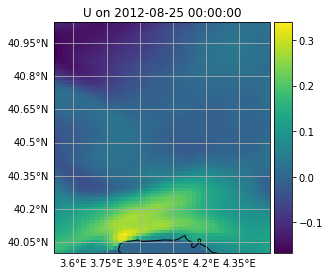

In [8]:
#We can create a FieldSet just like we do for normal grids. Note that NEMO is discretised on a C-grid
variables = {
            "U": "SSU",
            "V": "SSV",
            }
#    "waterdepth": "Depth",
standard_dims = {"lon": "XC", "lat": "YC", "time": "time"}
dims = {
        "U": standard_dims,
        "V": standard_dims,
       }
fieldset = FieldSet.from_xarray_dataset(
                                        ds,
                                        variables=variables,
                                        dimensions=dims,
                                        interp_method="cgrid_velocity",
                                        )
fieldset.U.show(show_time=timedelta(days=10).total_seconds())
# print(fieldset.U.grid.time)

---
### ParticleSet
Once you have set up the environment with the **FieldSet** object, you can start defining your particles in a **ParticleSet** object. 
This object requires:
> The FieldSet on which the particles live.  
> The type of Particle, which contains the information each particle will store.  
> The initial positions of the Particle, most notably the release locations in lon and lat

The different Particle types available are: 
> **JITParticle** : variables = (lon,lat,fieldset,dt,time)  
> **ScipyParticle** : variables = (lon,lat,depth,fieldset,time)

But it is very easy to create your own particle class which includes other Variables (see later)
JIT is always faster then SCIPY, so use JIT...

In [9]:
npart = 10
lon = [i for i in np.linspace(3.9, 4.2, npart)]
lat = [i for i in np.linspace(40.35, 40.65, npart)]

pset = ParticleSet.from_list(fieldset, JITParticle, lon=lon, lat=lat)

---
### ParticleFile
If you want to store the particle data generated in the simulation, you usually want to define the ParticleFile to which the output of the kernel execution will be written.

In [10]:
# define several dates
t_start = np64toDate(ds['time'][0].values)
t_end = np64toDate(ds['time'][-1].values)
dt_step = timedelta(hours=1.) # time step [hour]
dt_output = timedelta(hours=1.) # time between two storages of floats  [hour]
date_info(t_start, t_end, dt_step, dt_output)

# define the particle file in which the trajectories will be written
pfile = ParticleFile("trajectories", pset, outputdt=dt_output)

-------------------------------------------
start=2012-08-15 00:00  /  end=2012-09-14 01:00  /  dt=1:00:00  /  dt_output=1:00:00


---
### Kernel
After defining the **FieldSet** and the **ParticleSet**, we can run the parcels simulation by using **ParticleSet.execute()**. Running a simulation in parcels means executing kernels, little snippets of code that are run for each particle at each timestep.  

A few different kernels are included in Parcels (advection, diffusion, eos...)
> AdvectionEE (Explicit Euler)  
> AdvectionDiffusionEM (Euler-Maruyama scheme)  
> ...

Then, on the **ParticleSet** you have defined, you can use the method **ParticleSet.execute()** which requires the following arguments:

> The kernels to be executed.  
> **runtime=** how long the execution runs or **endtime=** at which time the execution stops.  
> **dt=** The timestep at which to execute the kernels.  
> **output_file=** The ParticleFile object to write the output to.  

In [11]:
# Make sure to remove the floats that start on land
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [12]:
# run the kernel to compute the trajectories
pset.execute(AdvectionRK4, 
             endtime=t_end, 
             dt=dt_step,
             output_file=pfile,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
            )

# export the trajectory data to a netcdf file
pfile.export()
pfile.close()

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/mv/gcjk3g210052g3q570q9k_60000gpr/T/parcels-16088/libe0ce9771dcfe98265c9dfbd76e0c73dd_0.so


---
### Plot the trajectories

In [13]:
# Open the netcdf file containing the trajectories
df = xr.open_dataset('trajectories.nc').to_dataframe().set_index('time').dropna()
print(df)

                     trajectory        lat       lon    z
time                                                     
2012-08-15 00:00:00         0.0  40.350000  3.900000  0.0
2012-08-15 00:00:00         1.0  40.383333  3.933333  0.0
2012-08-15 00:00:00         2.0  40.416667  3.966667  0.0
2012-08-15 00:00:00         3.0  40.450000  4.000000  0.0
2012-08-15 00:00:00         4.0  40.483333  4.033333  0.0
...                         ...        ...       ...  ...
2012-08-22 17:00:00         4.0  40.902010  4.487923  0.0
2012-08-22 18:00:00         0.0  41.021190  4.481403  0.0
2012-08-22 17:00:00         4.0  40.902010  4.487923  0.0
2012-08-22 19:00:00         0.0  41.023454  4.486593  0.0
2012-08-22 19:00:00         0.0  41.023454  4.486593  0.0

[1650 rows x 4 columns]


(<Figure size 504x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'2012-08-15 00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

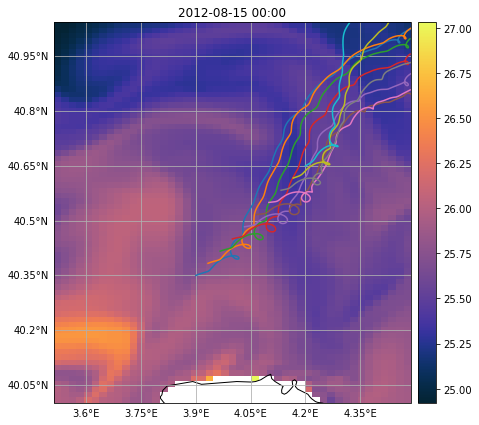

In [14]:
# Plot last t_delta days of the simulation
vmin = math.ceil(ds['SST'].min().values)
vmax = math.floor(ds['SST'].max().values)

# kwargs = dict(
#               #drifter_kwargs={"color": "white"},
#               drifter_kwargs={},
#               bg_kwargs = {'vmin': vmin,'vmax': vmax, 'cmap':cm.thermal}
#              )

bg_var = ds['SST'].sel(time=t_start)
plot_pretty(bbox, trails=df, bg_var=bg_var, date=t_start) #, **kwargs)

---
### Add variables in the FielSet

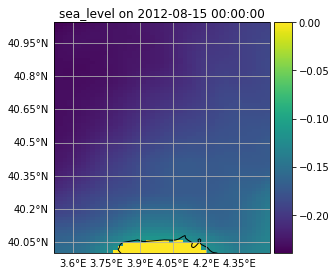

In [15]:
# add variable sea-level in the FieldSet (Eta in the dataset)
variables.update({"sea_level": "Eta"})
dims.update({"sea_level": standard_dims})

fieldset = FieldSet.from_xarray_dataset(
                ds,
                variables=variables,
                dimensions=dims,
                interp_method="cgrid_velocity",
            )
fieldset.sea_level.show()

---
### Create new particle from the JITParticle

In [16]:
class Particle_Extended(JITParticle):
    zonal_velocity = Variable('zonal_velocity', dtype=np.float32)
    meridional_velocity = Variable('meridional_velocity', dtype=np.float32)
    sea_level = Variable('sea_level', dtype=np.float32)

---
### Create new kernel to sample the new variables of the particle

In [17]:
def Kernel_Sample(particle, fieldset, time):
    particle.zonal_velocity, particle.meridional_velocity = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    particle.sea_level = fieldset.sea_level[time, particle.depth, particle.lat, particle.lon]

---
### Create the new particleSet and execute the new kernel

In [18]:
# create time array to delay the release of the drifters (every 6h)
time = np.arange(0, npart) * timedelta(hours=12).total_seconds() 

# Create the ParticleSet on the new Particle_Extended
pset = ParticleSet.from_list(
                            fieldset=fieldset,
                            pclass=Particle_Extended,
                            lon=lon,
                            lat=lat,
                            time=time,
                            )

# convert the python method into a parcels Kernel object
k_sample = pset.Kernel(Kernel_Sample) 

# define the particle file in which the trajectories will be written
pfile = ParticleFile("trajectories", pset, outputdt=dt_output)

# by only executing the sample kernel only we record the initial variable of the particles
pset.execute(k_sample, dt=0)  

# run the kernels to compute the trajectories and interpolate new variables of the particle
pset.execute(AdvectionRK4 + k_sample, 
             endtime=t_end, 
             dt=dt_step,
             output_file=pfile,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
            )

# export the trajectory data to a netcdf file
pfile.export()
pfile.close()

INFO: Compiled ArrayParticle_ExtendedKernel_Sample ==> /var/folders/mv/gcjk3g210052g3q570q9k_60000gpr/T/parcels-16088/libb865f14a945b38f3d1ff2d8169d74fe0_0.so
INFO: Compiled ArrayParticle_ExtendedAdvectionRK4Kernel_Sample ==> /var/folders/mv/gcjk3g210052g3q570q9k_60000gpr/T/parcels-16088/lib4fc85bda4a29b87852c032a5d1076f05_0.so


---
### Plot trajectories

In [19]:
plotTrajectoriesFile('trajectories.nc',mode='movie2d_notebook')

---
### Open netcdf file which contains the trajectories

In [20]:
df = xr.open_dataset('trajectories.nc').to_dataframe().set_index('time').dropna()
print(df)

                     trajectory        lat       lon    z  zonal_velocity  \
time                                                                        
2012-08-15 00:00:00        10.0  40.350000  3.900000  0.0    2.319899e-06   
2012-08-15 12:00:00        11.0  40.383333  3.933333  0.0    2.193127e-06   
2012-08-16 00:00:00        12.0  40.416667  3.966667  0.0   -1.068029e-06   
2012-08-16 12:00:00        13.0  40.450000  4.000000  0.0    1.269598e-06   
2012-08-17 00:00:00        14.0  40.483333  4.033333  0.0    3.174671e-07   
...                         ...        ...       ...  ...             ...   
2012-08-22 16:00:00        10.0  41.015569  4.470254  0.0    1.402704e-06   
2012-08-22 17:00:00        10.0  41.018606  4.475859  0.0    1.536434e-06   
2012-08-22 18:00:00        10.0  41.021190  4.481403  0.0    1.563216e-06   
2012-08-22 19:00:00        10.0  41.023454  4.486593  0.0    1.500128e-06   
2012-08-22 19:00:00        10.0  41.023454  4.486593  0.0    1.500128e-06   

---
### Callback functions 
Functions that are to be called after each iteration of the kernel or every **callbackdt** step if defined

In [21]:
def hello():
    print('Hello!')

In [22]:
endtime = t_start + timedelta(hours=10)
variables = { "U": "SSU", "V": "SSV" }
standard_dims = {"lon": "XC", "lat": "YC", "time": "time"}
dims = { "U": standard_dims, "V": standard_dims }
fieldset = FieldSet.from_xarray_dataset(
                                        ds,
                                        variables=variables,
                                        dimensions=dims,
                                        interp_method="cgrid_velocity",
                                        )
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lon, lat=lat)
pfile = ParticleFile("trajectories", pset, outputdt=dt_output)
pset.execute(AdvectionRK4, 
             endtime=endtime, 
             dt=dt_step,
             output_file=pfile,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             postIterationCallbacks=[hello],
             callbackdt=dt_step*2
            )

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/mv/gcjk3g210052g3q570q9k_60000gpr/T/parcels-16088/libe186eef222b992f9063b03f32ac5c0b7_0.so


Hello!
Hello!
Hello!
Hello!
Hello!



---
### Experimental features
. Parallel execution   
. Compute particles in any vertical coordinate model  
. Particle-Particle interaction  
. Particle-Field interaction  
. New 3D using advection kernel  


### Future development goals
. Complex three-dimensional particle diffusion  
. Support for unstructured grids  

In [23]:
from ipywidgets import Video
video = Video.from_file('llc4320_drifters_0.mp4')
video

Video(value=b'\x00\x00\x00\x1cftypmp42\x00\x00\x00\x01isommp41mp42\x00\x00\x00\x01mdat\x00\x00\x00\x00\x00$xM\…